<h1>Readme</h1>
This file procures a small example dataset for MNIST, then applies MDBPE to it. After 

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
import random

<h1>0. Setup</h1>

In [2]:
WIDTH, HEIGHT = 12, 12
#stop BPE at what number of tokens? --> hyper parameter to evaluate
MAXIMUM_NUMBER_OF_TOKENS = 256+32 #256 = only use the base tokens, 256+32 --> use 32 extra tokens to compact stuff into
LIMITED_EXAMPLES = 100 #--> only use a subset of the data (for debugging); set to "None" to use all data

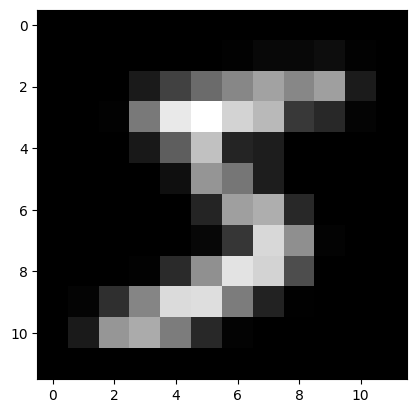

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#resize to WIDTH-by-HEIGHT
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((WIDTH, HEIGHT))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testnset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=8, shuffle=False)
test_loader = DataLoader(mnist_testnset, batch_size=8, shuffle=False)

def show(img):
    assert(len(img.size()) == 3)
    plt.imshow(img.clamp(0.0, 1.0).squeeze(), cmap='gray')
    plt.show()

for img, label in train_loader:
    show(img[0])
    break

In [4]:
for data, _ in train_loader:
    WIDTH, HEIGHT = data.size()[2], data.size()[3]
    break

<h1>1. Transcribe</h1>
Translate dataset into hard drive files:<br/>
"transcribed_data" is the tensors of [uniqueIDs, classIDs]<br/>
"transcribed_data_og" are the ORIGINAL tensors, used to look up what actual base tokens a larger token is made up of

In [5]:
#remove path "transcribed_data" and "transcribed_data_test" if they exist (start with clean slate)
import os
import shutil
if os.path.exists("transcribed_data"):
    shutil.rmtree("transcribed_data")
if os.path.exists("transcribed_data_og"):
    shutil.rmtree("transcribed_data_og")
if os.path.exists("tokensequences"):
    shutil.rmtree("tokensequences")
if os.path.exists("tokenshapes"):
    shutil.rmtree("tokenshapes")
#create folder "transcribed data"
import os
if not os.path.exists('transcribed_data'):
    os.makedirs('transcribed_data')
if not os.path.exists('transcribed_data_og'):
    os.makedirs('transcribed_data_og')
#creat subfolders
FILE_MODULO = 128 #number of subfolders, make sure this is something large for e.g. ImageNet
assert(len(train_loader.dataset) / FILE_MODULO < 500)
for i in range(FILE_MODULO):
    if not os.path.exists('transcribed_data/' + str(i)):
        os.makedirs('transcribed_data/' + str(i))
    if not os.path.exists('transcribed_data_og/' + str(i)):
        os.makedirs('transcribed_data_og/' + str(i))

In [6]:
#go over (first few) elements, then write to file as tokens:
#write both the token class (e.g. "what greyscale value")
#and the unique id (for now: just a unique ID per pixel, later one a unique ID per constellation of pixels made up from multiple tokens (index of the token; first token with all its pixels will be 0, second token with all its pixels will be 1, etc.))
its = 0
unique = None
for img, label in train_loader:
    #make sure we can save some unique ID per token
    if unique is None:
        unique = torch.zeros_like(img[0,0].clone()).long()
        for x in range(0, img.size()[2]):
            for y in range(0, img.size()[3]):
                unique[x][y] = x * img.size()[2] + y
    #turn into tokens; later replace with VQ-VAE
    img *= 255.0
    img = img.int()

    for k in range(0, img.size()[0]):
        torch.save([unique, img[k,0].clone()], "transcribed_data/"+str(its%FILE_MODULO)+"/"+str(its)+".dat")
        torch.save(img[k,0].clone(), "transcribed_data_og/"+str(its%FILE_MODULO)+"/"+str(its)+".dat")
        
        its += 1
        if LIMITED_EXAMPLES != None and its >= LIMITED_EXAMPLES:
            break
        
    if LIMITED_EXAMPLES != None and its >= LIMITED_EXAMPLES:
        break

<h1>2. Start BPE</h2>

In [7]:
#create a unique dataloader that loads everything from the transcribed data folder:
class UniqueDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.files = []
        #recursively get all files in the folder
        for i in range(FILE_MODULO):
            for root, dirs, files in os.walk("transcribed_data/" + str(i)):
                for file in files:
                    self.files.append(str(i) + "/" + file)
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        unique, classes = torch.load("transcribed_data/" + self.files[idx], weights_only=False)
        return unique, classes, "transcribed_data/" + self.files[idx]

unique_train = UniqueDataset()
for a, _, _ in unique_train:
    display_colours = torch.rand(3, a.size()[0] * a.size()[1]) #random colours for visualisation
    break

In [8]:
def visualise_unique(input):
    #get a list of unique colours - at most, n-by-n unique colours
    global display_colours
    #for a given input image with size [n x n], visualise the unique tokens with a different color
    assert(len(input.size()) == 2)
    
    img = display_colours.clone()[:,input.view(-1)].view(3, input.size()[0], input.size()[1])
    #show the [3 x n x n] image:

    plt.imshow(img.permute(1, 2, 0))
    #make sure plt shows during the execution
    plt.show()

In [9]:
#find largest token in data
NEW_TOKEN_ID = -1 #new token id for the centre
for unique, classes, path in unique_train:
    NEW_TOKEN_ID = max(NEW_TOKEN_ID, torch.max(classes).item())
NEW_TOKEN_ID += 1

In [10]:
print("NEW TOKEN STARTS AT ", NEW_TOKEN_ID)
START_OF_NEW_TOKENS = NEW_TOKEN_ID

CODEWORDS_TO_ADD = MAXIMUM_NUMBER_OF_TOKENS - START_OF_NEW_TOKENS

NEW TOKEN STARTS AT  254


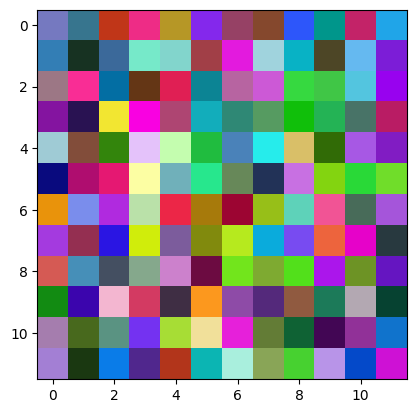



---> DONE ADDING CODEWORD 1 / 34 , (POSSIBLY) REPEATING... Time left (est.):  2.047160255908966 




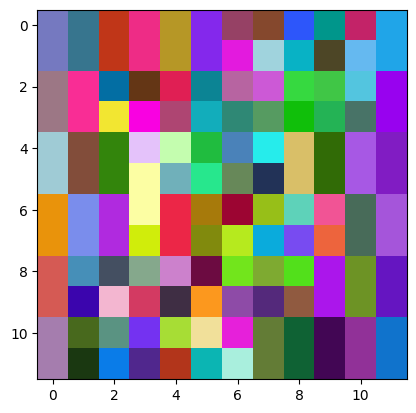



---> DONE ADDING CODEWORD 2 / 34 , (POSSIBLY) REPEATING... Time left (est.):  2.0127880732218424 




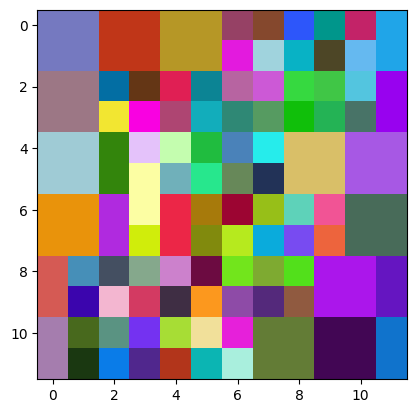



---> DONE ADDING CODEWORD 3 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.919464581542545 




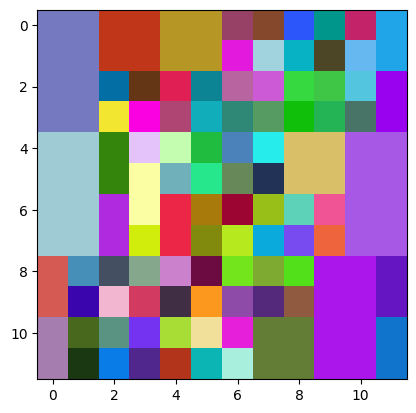



---> DONE ADDING CODEWORD 4 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.8220723867416382 




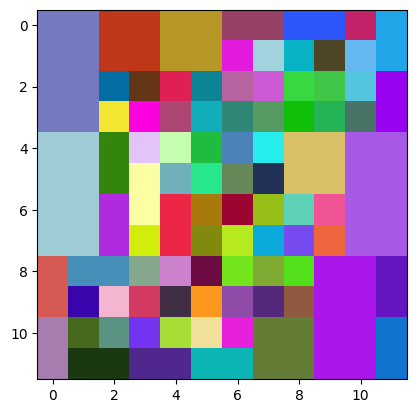



---> DONE ADDING CODEWORD 5 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.727076806227366 




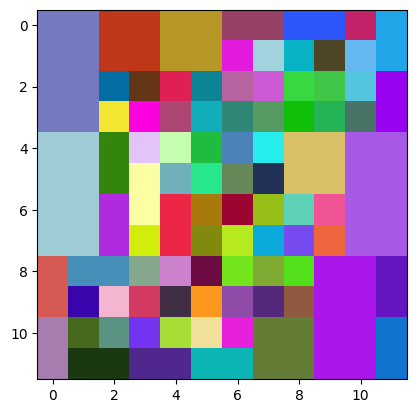



---> DONE ADDING CODEWORD 6 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.63190545241038 




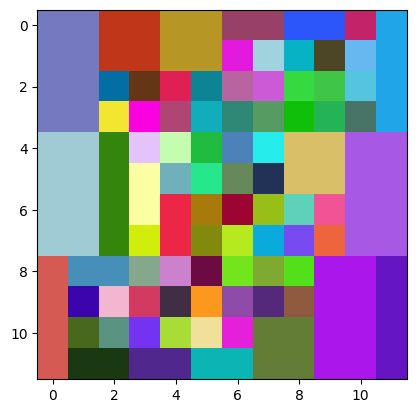



---> DONE ADDING CODEWORD 7 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.5575438925198146 




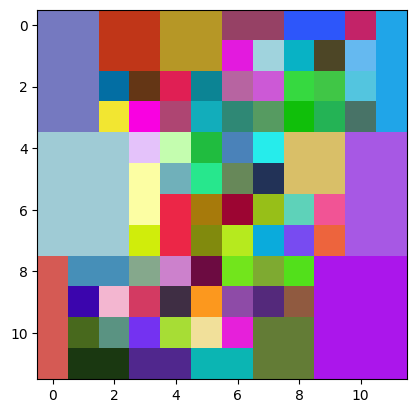



---> DONE ADDING CODEWORD 8 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.470137243469556 




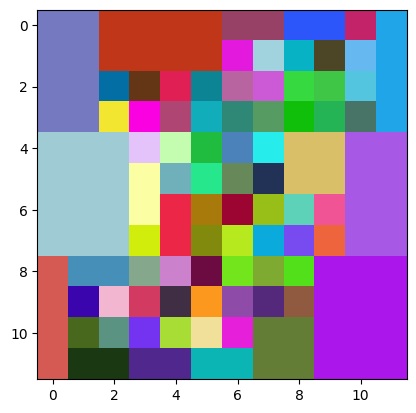



---> DONE ADDING CODEWORD 9 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.3991328963526972 




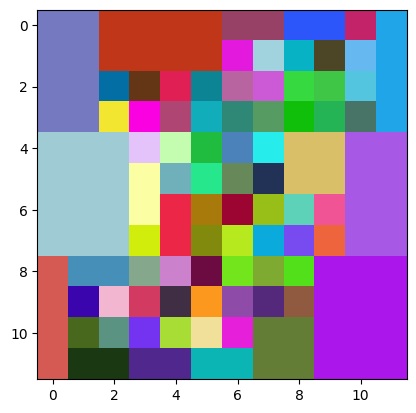



---> DONE ADDING CODEWORD 10 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.3255136871337891 




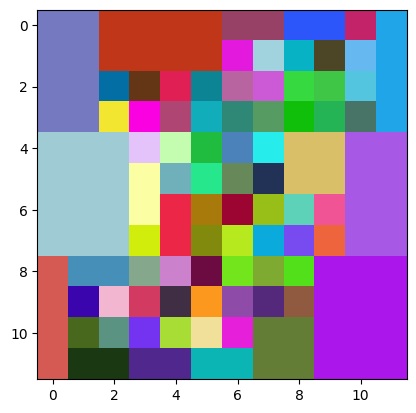



---> DONE ADDING CODEWORD 11 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.2543836958480603 




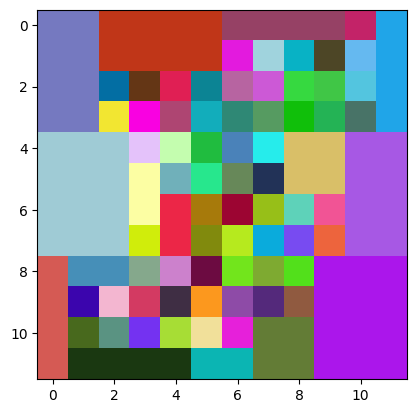



---> DONE ADDING CODEWORD 12 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.1864927272001902 




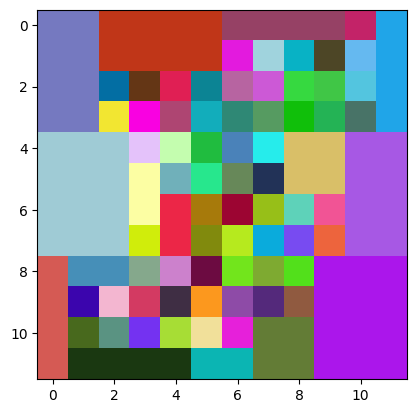



---> DONE ADDING CODEWORD 13 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.1160668428127585 




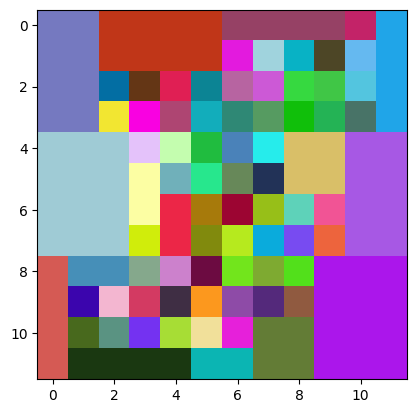



---> DONE ADDING CODEWORD 14 / 34 , (POSSIBLY) REPEATING... Time left (est.):  1.0495477574212209 




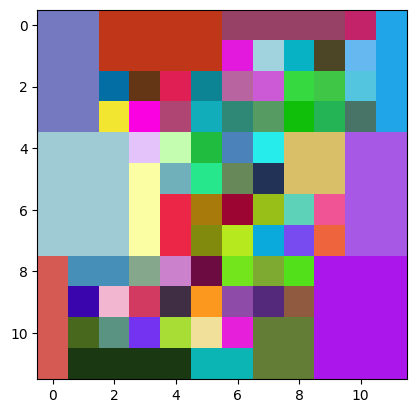



---> DONE ADDING CODEWORD 15 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.9906819627020094 




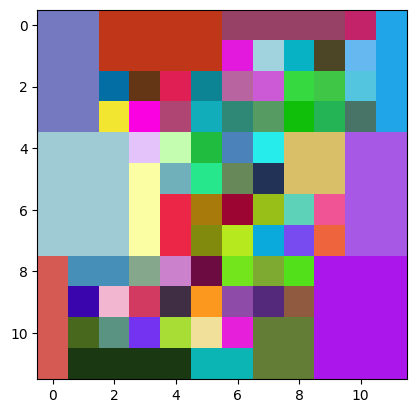



---> DONE ADDING CODEWORD 16 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.9289432659745216 




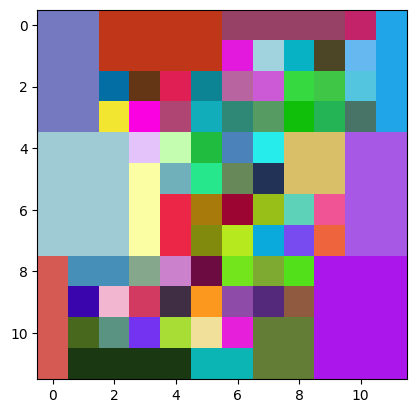



---> DONE ADDING CODEWORD 17 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.8718607068061829 




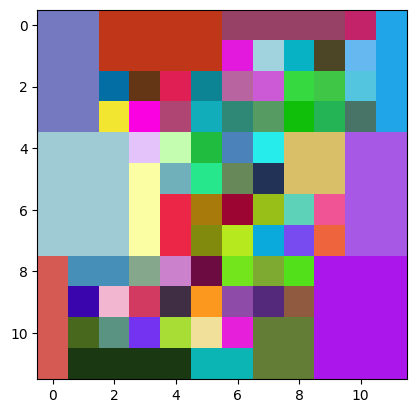



---> DONE ADDING CODEWORD 18 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.8131454220524541 




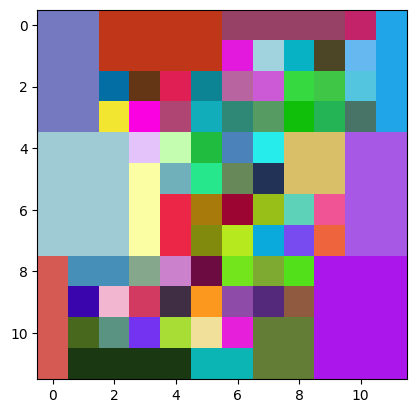



---> DONE ADDING CODEWORD 19 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.7563970496779994 




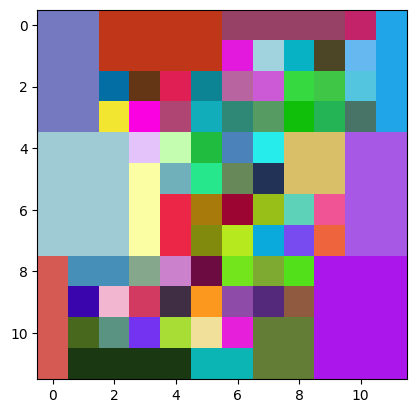

	DONE WITH  93.0 % on replacement pass


---> DONE ADDING CODEWORD 20 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.7007245103518168 




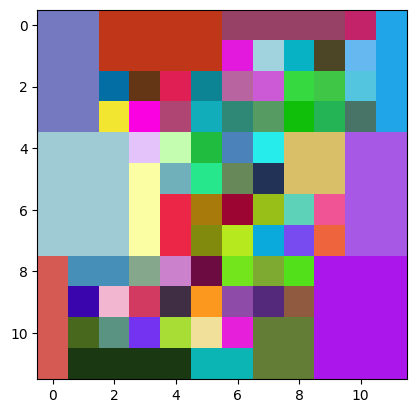



---> DONE ADDING CODEWORD 21 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.6453158755151053 




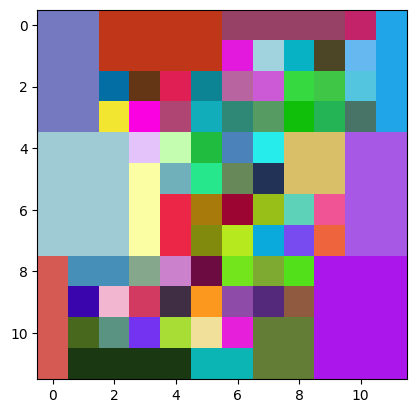



---> DONE ADDING CODEWORD 22 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.5914967862042514 




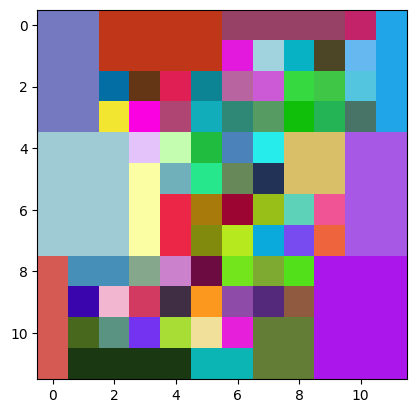



---> DONE ADDING CODEWORD 23 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.5383791336114856 




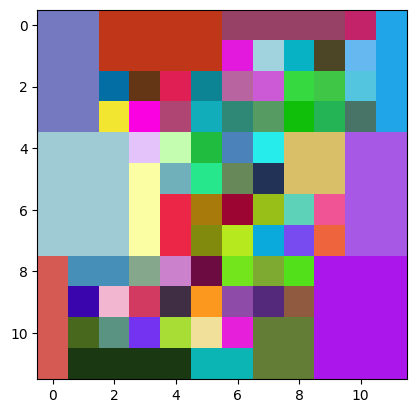



---> DONE ADDING CODEWORD 24 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.4866139392058055 




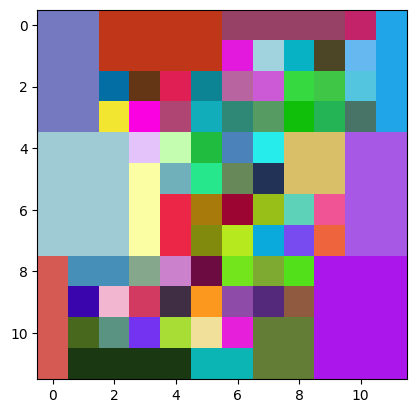



---> DONE ADDING CODEWORD 25 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.4358914647102356 




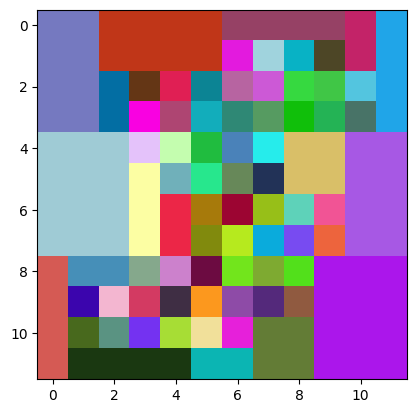



---> DONE ADDING CODEWORD 26 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.3856793097960643 




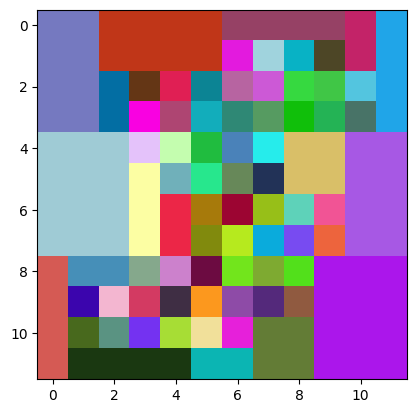



---> DONE ADDING CODEWORD 27 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.3354682881155132 




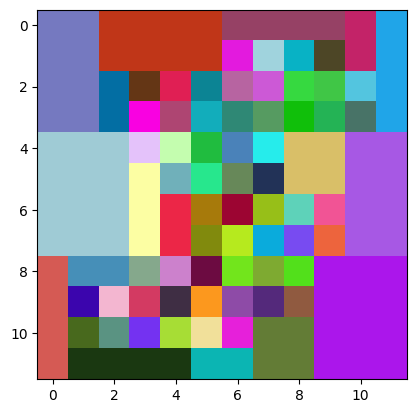



---> DONE ADDING CODEWORD 28 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.28643013068607875 




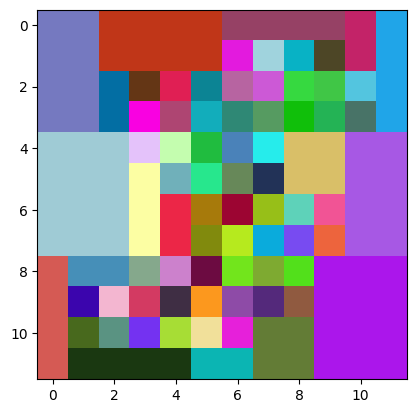



---> DONE ADDING CODEWORD 29 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.237611945333152 




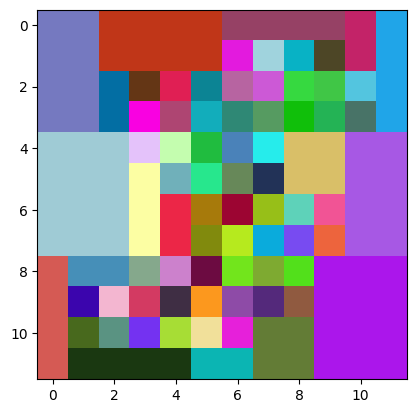



---> DONE ADDING CODEWORD 30 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.18910922686258952 




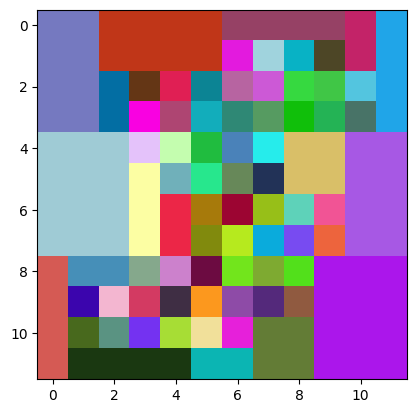



---> DONE ADDING CODEWORD 31 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.14112119020954253 




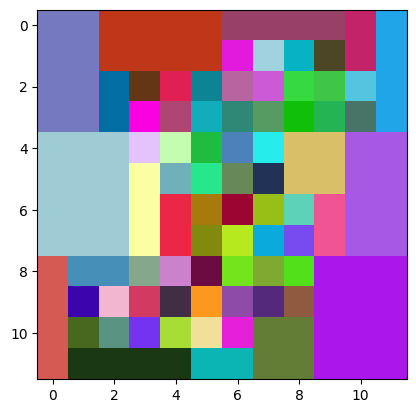



---> DONE ADDING CODEWORD 32 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.09374614035089811 




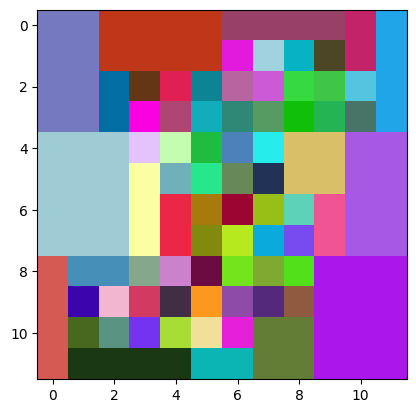



---> DONE ADDING CODEWORD 33 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.04669556581612789 




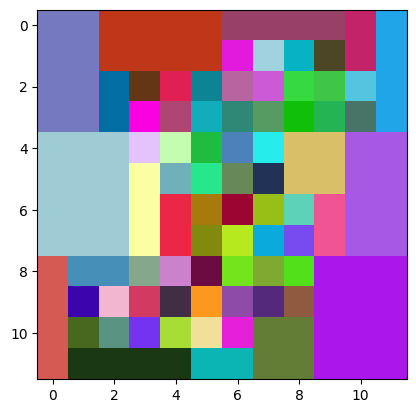



---> DONE ADDING CODEWORD 34 / 34 , (POSSIBLY) REPEATING... Time left (est.):  0.0 




In [11]:
#get the anchor point of the token constellation: identify the most left token in the upper most row - conveniently, this is the first occurence of the unique ID
def get_anchor(unique, pos_x, pos_y):
    id = unique[pos_x][pos_y]
    #find most top-left corner of the id
    #get all occurences of id:
    top_left = torch.nonzero(unique == id)[0]
    return top_left

CODEWORDS_ADDED = 0
token_path_sizes = {}

time_start = time.time()
last_output = time_start
rules = []
while NEW_TOKEN_ID < MAXIMUM_NUMBER_OF_TOKENS:
    #re-load dataset to make sure we always can merge stuff
    unique_train = UniqueDataset() #TODO speedup

    #############################
    ########## STEP 1 ###########
    ## go over data, count BPs  #
    #############################

    #actual BPE:

    #pass 1: count occurences of every unique token constellation in both direction
    map_bpe = None
    map_bpe = {}
    it = 0
    for unique, classes, _ in unique_train: #TODO speedup: use some parts
        if time.time() - last_output > 60:
            print("\tDONE WITH ",it/ len(unique_train)*100,"% on counting pass")
            last_output = time.time()

        if it == 0:
            visualise_unique(unique)
            
        it += 1

        #go over every pixel coordinate, track which ocurs most often:
        used = {}
        for x in range(0, unique.size()[0]):
            for y in range(0, unique.size()[1]):
                #get the two possible alignments of our box, horizontal and vertical:
                for n in [(x+1,y), (x,y+1)]: 
                    n_x, n_y = n[0], n[1] #position of our neighbour token, i.e. for two neighbouring tokens: [x,y][n_x,n_y]
                    #skip if neighbour is out of bounds
                    if n_x >= unique.size()[0] or n_y >= unique.size()[1]:
                        continue

                    #skip if they're the same unique ID (=we can't merge a single large token with itself)
                    if unique[x][y] == unique[n_x][n_y]:
                        continue

                    #find the class ID (greyscale value/later larger token values) of the two elements under our byte pair mask
                    class_a, class_b = classes[x][y].item(), classes[n_x][n_y].item()
                    #find the anchor points to identify the constellation they're in
                    anchor_a, anchor_b = get_anchor(unique, x, y), get_anchor(unique, n_x, n_y)
                    
                    #only do every centre pair once - if we already looked at two unique tokens, we don't need to look at them again (for this one image):
                    #   two unique tokens at specific positions are only counted once
                    if not (anchor_a, anchor_b) in used:
                        used[(anchor_a, anchor_b)] = True
                    else:
                        continue

                    #compute vector from anchor to anchor to uniquely identify the constellation
                    v = (anchor_a - anchor_b)
                    
                    #count occurence of this constellation of features:
                    if not (class_a, class_b, v[0].item(), v[1].item()) in map_bpe:
                        #add if not in map
                        map_bpe[(class_a, class_b, v[0].item(), v[1].item())] = 1
                    else: #just increment
                        map_bpe[(class_a, class_b, v[0].item(), v[1].item())] += 1
                    
    #############################
    ########## STEP 2 ###########
    # find monst frequent pair ##
    #############################

    max = 0
    max_key = None
    for key in map_bpe:
        if map_bpe[key] > max:
            max = map_bpe[key]
            max_key = key
    
    #save which tokens in what constellation we merge - these are basically the rules we need to alter "encode" new images: which tokens (0,1) in what constellation (2,3) are merged
    #we can use for new images: just go over this loop, but load from the rules instead of the original data and we're golden
    rules.append([max_key[0], max_key[1], max_key[2], max_key[3]])

    #############################
    ########## STEP 3 ###########
    ### replace most frequent ###
    ###### with new token #######
    #############################

    #go over the data a second time; this time: identify all occurences of the most frequent BPE
    #and replace them with a new token
    it = 0
    total_saved = 0
    for unique, classes, path in unique_train:
        if time.time() - last_output > 60:
            print("\tDONE WITH ",it/ len(unique_train)*100,"% on replacement pass")
            last_output = time.time()
        
        changed = False
        used_uniques = {}
        for x in range(0, unique.size()[0]):
            for y in range(0, unique.size()[1]):
                if unique[x][y].item() in used_uniques: #skip if we already replaced this unique ID
                    continue
                #get the neighbours
                for n in [(x+1,y), (x,y+1)]: 
                    #skip if neighbour is out of bounds
                    n_x, n_y = n[0], n[1]
                    if n_x >= unique.size()[0] or n_y >= unique.size()[1]:
                        continue
                    if unique[n_x][n_y].item() in used_uniques: #skip if we already replaced this neighbour unique ID (this token has already been merged this pass)
                        continue

                    #skip if they're the same unique ID
                    if unique[x][y] == unique[n_x][n_y]:
                        continue
                    
                    #find the token classes we merge, i.e. the greyscale values (intially) or the token IDs (later)
                    class_a, class_b = classes[x][y].item(), classes[n_x][n_y].item()
                    
                    #only if the classes fit, even further consider if we're at the right place to merge
                    if max_key[0] != class_a or max_key[1] != class_b:
                        continue
                    
                    #get the centres
                    anchor_a, anchor_b = get_anchor(unique, x, y), get_anchor(unique, n_x, n_y)
                    
                    v = (anchor_a - anchor_b)
                    vx = v[0].item()
                    vy = v[1].item()
                    
                    #check if V matches, i.e. check if we're EXACTLY at the right place to merge:
                    if max_key[2] == vx and max_key[3] == vy:
                        a_unique = unique[x][y]

                        #replace with new token:
                        #   replace unique ID of every part of the SECOND token with the first one;
                        #   the unique ID of the first one stays the same

                        #replace the A item
                        indices_to_relabel_a = torch.nonzero(unique == unique[x,y])
                        indices_to_relabel_b = torch.nonzero(unique == unique[n_x,n_y])
                        
                        #replace the B item, both classID and uniqueID
                        for i in range(0, indices_to_relabel_b.size()[0]):
                            #   replace unique ID of the B element with the A one
                            unique[indices_to_relabel_b[i][0]][indices_to_relabel_b[i][1]] = a_unique
                            #   replace class ID of the B element with the new one
                            classes[indices_to_relabel_b[i][0]][indices_to_relabel_b[i][1]] = NEW_TOKEN_ID
                        #replace the classID (=what kind of token is this) of the A item; leave the unique ID as is
                        for i in range(0, indices_to_relabel_a.size()[0]):
                            #   replace class ID of the A element with the new one
                            classes[indices_to_relabel_a[i][0]][indices_to_relabel_a[i][1]] = NEW_TOKEN_ID
                        changed = True
                        used_uniques[unique[x][y].item()] = True
        
        #save if we changed something - yes, we do always safe, because later, e.g. ImageNet is 1TB large, we can't keep it in memory
        if changed:
            total_saved += 1
            torch.save([unique, classes], path)
        it += 1
    
    #increment token ID
    NEW_TOKEN_ID += 1
    assert(total_saved > 0)
    CODEWORDS_ADDED += 1
    
    time_so_far = time.time() - time_start

    time_so_far = time_so_far / CODEWORDS_ADDED * (CODEWORDS_TO_ADD - CODEWORDS_ADDED)

    print("\n\n---> DONE ADDING CODEWORD",CODEWORDS_ADDED,"/",CODEWORDS_TO_ADD,", (POSSIBLY) REPEATING... Time left (est.): ",time_so_far/60,"\n\n")
torch.save(rules, "rules.dat")

In [12]:
unique_train = UniqueDataset()

<h1>5. Export token shapes & sequences</h1>

In [13]:
#create folder tokenshapes
if not os.path.exists('tokenshapes'):
    os.makedirs('tokenshapes')
    
#export token shapes:
#we store a grid in the form of:
#[ -1  0  2  4 -1]
#[  2  1  3  5  6]
#[  2 -1 -1 -1 -1]
#[ -2 -1 -1 -1 -1]
#--> -1 means "empty/not this token", everything else are the ORIGINAL, underlying base token IDs
exported = {}
token_sizes = {}
for unique, classes, path in unique_train:
    path_v2 = path.replace("transcribed_data", "transcribed_data_og")
    tokens_original = torch.load(path_v2)
    total_size = 0
    uniques_exported = {}
    
    for x in range(0, unique.size()[0]):
        for y in range(0, unique.size()[1]):
            class_to_export = classes[x][y].item()
            if class_to_export not in exported:
                uid_to_export = unique[x][y].item()
                #find most left elmenet and most top element of the token (bounding box; if we'd take the top-left corner, like in the example in this cell, we'd cut stuff off!)
                most_left = WIDTH+1
                most_top = HEIGHT+1
                indices = torch.nonzero(unique == uid_to_export)
                for i in range(0, indices.size()[0]):
                    most_left = min(most_left, indices[i][0])
                    most_top = min(most_top, indices[i][1])
                
                #find diff to most left and most top - example at the top would have an offset of -1, 0
                offset_x = most_left - x
                
                crop_unique = unique.clone()[most_left:, most_top:]
                crop_classes = classes.clone()[most_left:, most_top:]
                crop_original = tokens_original.clone()[most_left:, most_top:]

                #remove everything that isn't the unique ID
                wrong = torch.nonzero(crop_unique != uid_to_export)
                for i in range(0, wrong.size()[0]):
                    crop_classes[wrong[i][0]][wrong[i][1]] = -1
                    crop_original[wrong[i][0]][wrong[i][1]] = -1
                
                #crop properly
                while (crop_classes[-1] != -1).sum() == 0:
                    crop_classes = crop_classes[:-1]
                    crop_original = crop_original[:-1]
                while (crop_classes[:,-1] != -1).sum() == 0:
                    crop_classes = crop_classes[:,:-1]
                    crop_original = crop_original[:,:-1]
                #count elements != -1:
                token_size = (crop_original != -1).sum().item()
                token_sizes[classes[x,y].item()] = token_size
                total_size += token_size
                
                uniques_exported[uid_to_export] = True
                torch.save([crop_original, offset_x], "tokenshapes/"+str(class_to_export)+".dat")
                exported[class_to_export] = True
            elif not unique[x][y].item() in uniques_exported: #track size of unique tokens that we exported
                total_size += token_sizes[classes[x,y].item()]
                uniques_exported[unique[x][y].item()] = True
    
    assert(total_size == WIDTH*HEIGHT)

<h3>Export token sequences - this also needs a position of the token!</h3>

In [14]:
#create folder tokensequences
if not os.path.exists('tokensequences'):
    os.makedirs('tokensequences')

for k in range(0, FILE_MODULO):
    if not os.path.exists('tokensequences/' + str(k)):
        os.makedirs('tokensequences/' + str(k))

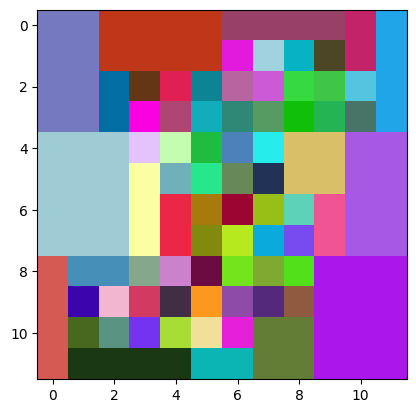

DONE EXPORTING  0 / 100  SEQUENCES, AVG LENGTH:  75.0 , compared to  144 , i.e.  52.083333333333336 % of the intial size


In [15]:
#export squences with positional information:
#go over the data a third item by item, export as sequence:
# [token_id, x, y]

index = 0
sequence_lengths = []
for unique, classes, _ in unique_train:
    #go over every pixel coordinate, write out sequence:
    sequence = []
    used_ids = {}
    for x in range(0, unique.size()[0]):
        for y in range(0, unique.size()[1]):
            #if a unique token does NOT exist already (=top left of it) --> add to sequence
            if unique[x][y].item() in used_ids:
                continue
            used_ids[unique[x][y].item()] = True
            sequence.append([classes[x][y].item(), x, y])
    if index == 0:
        visualise_unique(unique)
    sequence_lengths.append(len(sequence))
    if index % 100 == 0:
        print("DONE EXPORTING ",index,"/",len(unique_train)," SEQUENCES, AVG LENGTH: ",sum(sequence_lengths)/len(sequence_lengths),", compared to ",WIDTH*HEIGHT,", i.e. ",sum(sequence_lengths)/len(sequence_lengths)/(WIDTH*HEIGHT)*100,"% of the intial size")
    #check if folder tokensequences/index exists:
    torch.save(sequence, "tokensequences/"+str(index % FILE_MODULO)+"/"+str(index)+".dat")
    index += 1

<h1>6. Testwise load sequence & render it<h1>

<h3>Follow the same procedure:<br/>
-predict a token<br/>
-fill out the grid with the whole token shape
-
</h3>

In [16]:
DUMMY_CASE = True

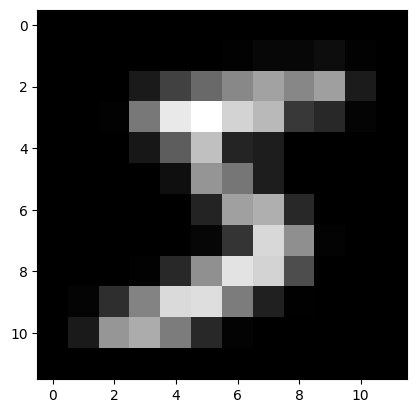

In [17]:
def resolve_token(grid, token_to_put, x, y):
    #load full token shape, then put one of the original ones into grid:
    if token_to_put < START_OF_NEW_TOKENS:
        #traditional, 1-by-1 token - just write it and be done
        grid[x, y] = token_to_put
        return grid
    tokendata = torch.load("tokenshapes/"+str(token_to_put)+".dat")
    tokenshape = tokendata[0]
    offset_x = tokendata[1]
    for tx in range(0, tokenshape.size()[0]):
        for ty in range(0, tokenshape.size()[1]):
            if tokenshape[tx, ty] != -1:
                grid[x + tx + offset_x, y + ty] = tokenshape[tx, ty]
    return grid

def generate_sequence(width, height):
    #make sure we have a shape that tells us if a token has been (implicitly) generated
    #-1 = not generated yet
    output_tokens = torch.ones(width, height).long() * -1
    
    sequence_index, sequence_x, sequence_y = 0, 0, 0 #current position in generative process
    current_sequence = []
    #first at 0/0:
    if DUMMY_CASE:
        #just load first token from sequence
        dummy_sequence = torch.load("tokensequences/0/0.dat")

        #add the first code ala [token, x, y] to the sequence
        current_sequence.append(dummy_sequence[0])
        #enter tokens into output token grid:
        output_tokens = resolve_token(output_tokens, dummy_sequence[sequence_index][0], dummy_sequence[sequence_index][1], dummy_sequence[sequence_index][2])
        sequence_index += 1
    else:
        #draw from probability distribution
        assert(False)
    
    #as long as there's token to generate
    while (output_tokens == -1).long().sum() > 0:
        if DUMMY_CASE:
            #fish next token from our sequence list
            sequence = dummy_sequence[sequence_index]
            sequence_x, sequence_y = sequence[1], sequence[2]
            assert(output_tokens[sequence_x, sequence_y] == -1)
            next_token = sequence[0]
        else:
            #generate next token from "current_sequence"; clamp probabilities according to token shapes
            #--> find next -1, set sequence_x, sequence_y accordingly & sample to set "next_token"
            assert(False)
        
        #put token in
        current_sequence.append([next_token, sequence_x, sequence_y])
        #enter tokens into output token grid:
        output_tokens = resolve_token(output_tokens, next_token, sequence_x, sequence_y)
    
        sequence_index += 1

    #todo: decode with VQ-VAE
    return output_tokens

show(generate_sequence(WIDTH, HEIGHT)[None].float() / 255.0)